# Reproducing arXiv:1811.08782v1

This notebook is an attempt to reproduce `Solving Nonlinear and High-Dimensional Partial Differential Equations via Deep Learning` (https://arxiv.org/abs/1811.08782v1).

**ABSTRACT**  
In this work we apply the Deep Galerkin Method (DGM) described in Sirignano and Spiliopoulos (2018) to solve a number of partial differential equations that arise in quantitative finance applications including option pricing, optimal execution, mean field games, etc. The main idea behind DGM is to represent the unknown function of interest using a deep neural network. A key feature of this approach is the fact that, unlike other commonly used numerical approaches such as finite difference methods, it is mesh-free. As such, it does not suffer (as much as other numerical methods) from the curse of dimensionality associated with highdimensional PDEs and PDE systems. The main goals of this paper are to elucidate the features, capabilities and limitations of DGM by analyzing aspects of its implementation for a number of different PDEs and PDE systems. Additionally, we present: (1) a brief overview of PDEs in quantitative finance along with numerical methods for solving them; (2) a brief overview of deep learning and, in particular, the notion of neural networks; (3) a discussion of the theoretical foundations of DGM with a focus on the justification of why this method is expected to perform well.

**REFERENCES**
- https://github.com/adolfocorreia/DGM


In [2]:
import time
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from math import pi # to get the definition of pi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## I) Problem Definition

This is a thermal problem.

In [3]:
k = 400 #thermal conductivity of copper
stefanBoltz = 5.670373e-8 # stefan-boltzman cst
h = 1 #plate size
Tb = 1000 #temperature of the bottom
epsilon=0.5 # emissivity
rho = 8960 # Copper density
Cp=386 #specific heat
Ta = 300 #ambient temperature
tz = 0.01 # plate thickness

#for ease of use
a = rho*Cp*tz
b = -k*tz
c = 2*h
d = 2*stefanBoltz*epsilon

In [4]:
n = 25
L=h
#bottom edge
rand_L = np.random.rand(n) * L 
discr_s1 = (np.array([rand_L.transpose(), np.zeros(n)])).transpose()

#other edges
border = np.ones([n])*L
rand_L = np.random.rand(n) * L 
discr_s2_1 = np.array([border, rand_L.transpose()]).transpose()
rand_L = np.random.rand(n) * L 
discr_s2_2 = np.array([rand_L.transpose(), border]).transpose()
rand_L = np.random.rand(n) * L 
discr_s2_3 = np.array([np.zeros(n), rand_L.transpose()]).transpose()

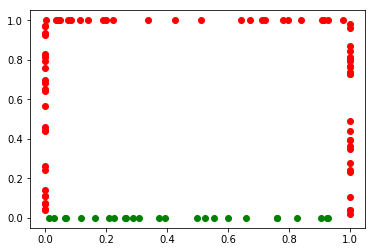

In [5]:
plt.plot(discr_s1[:,0],discr_s1[:,1], 'go')
plt.plot(discr_s2_1[:,0],discr_s2_1[:,1],'ro') 
plt.plot(discr_s2_2[:,0],discr_s2_2[:,1],'ro') 
plt.plot(discr_s2_3[:,0],discr_s2_3[:,1],'ro') 

In [6]:
n=200
discr_om = np.array([np.random.rand(n), np.random.rand(n)]).transpose() * L
discr_om = discr_om[np.where((np.abs(discr_om[:,0])< L-0.02))]
discr_om = discr_om[np.where((np.abs(discr_om[:,1])< L-0.02))]
discr_om = discr_om[np.where((np.abs(discr_om[:,0])> 0.02))]
discr_om = discr_om[np.where((np.abs(discr_om[:,1])> 0.02))]

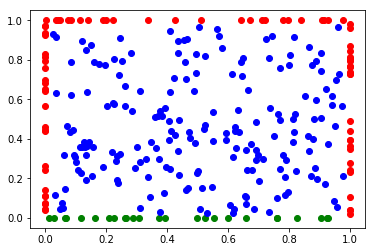

In [7]:
plt.plot(discr_s1[:,0],discr_s1[:,1], 'go')
plt.plot(discr_s2_1[:,0],discr_s2_1[:,1],'ro') 
plt.plot(discr_s2_2[:,0],discr_s2_2[:,1],'ro') 
plt.plot(discr_s2_3[:,0],discr_s2_3[:,1],'ro') 
plt.plot(discr_om[:,0],discr_om[:,1],'bo')

In [8]:
discr_t = np.linspace(0.1,200,20)

In [9]:
size_om = discr_om.shape[0]
size_s1 = discr_s1.shape[0]
size_s2 = discr_s2_1.shape[0]

discr_om_t = np.concatenate((discr_om, np.ones([size_om,1])*discr_t[0]), axis=1)
discr_s1_t = np.concatenate((discr_s1, np.ones([size_s1,1])*discr_t[0]), axis=1)
discr_s2_1_t = np.concatenate((discr_s2_1, np.ones([size_s2,1])*discr_t[0]), axis=1)
discr_s2_2_t = np.concatenate((discr_s2_2, np.ones([size_s2,1])*discr_t[0]), axis=1)
discr_s2_3_t = np.concatenate((discr_s2_3, np.ones([size_s2,1])*discr_t[0]), axis=1)
discr_om_0 = np.concatenate((discr_om, np.ones([size_om,1])*0), axis=1)
for i in range(discr_t.size - 1 ):
    discr_om_t_temp = np.concatenate((discr_om, np.ones([size_om,1])*discr_t[i+1]), axis=1)
    discr_om_t = np.concatenate((discr_om_t, discr_om_t_temp))
    
    discr_s1_t_temp = np.concatenate((discr_s1, np.ones([size_s1,1])*discr_t[i+1]), axis=1)
    discr_s1_t = np.concatenate((discr_s1_t, discr_s1_t_temp))
    
    discr_s2_t_temp = np.concatenate((discr_s2_1, np.ones([size_s2,1])*discr_t[i+1]), axis=1)
    discr_s2_1_t = np.concatenate((discr_s2_1_t, discr_s2_t_temp))
    
    discr_s2_t_temp = np.concatenate((discr_s2_1, np.ones([size_s2,1])*discr_t[i+1]), axis=1)
    discr_s2_2_t = np.concatenate((discr_s2_2_t, discr_s2_t_temp))
    
    discr_s2_t_temp = np.concatenate((discr_s2_3, np.ones([size_s2,1])*discr_t[i+1]), axis=1)
    discr_s2_3_t = np.concatenate((discr_s2_3_t, discr_s2_t_temp))
    
discr_s2_t = np.concatenate((discr_s2_1_t,discr_s2_2_t,discr_s2_3_t))

print(discr_om_t.shape,discr_s1_t.shape,discr_s2_t.shape, discr_om_0.shape)


discr_om_t = torch.tensor(discr_om_t, requires_grad=True).to(torch.float32).cuda()
discr_s1_t = torch.tensor(discr_s1_t, requires_grad=True).to(torch.float32).cuda()
discr_s2_t = torch.tensor(discr_s2_t, requires_grad=True).to(torch.float32).cuda()
discr_om_0 = torch.tensor(discr_om_0, requires_grad=True).to(torch.float32).cuda()

data = torch.cat((discr_om_0, discr_om_t, discr_s1_t, discr_s2_t)); 
size_om_t,size_s1, size_s2,size_om_0 = discr_om_t.shape[0],discr_s1_t.shape[0],discr_s2_t.shape[0], discr_om_0.shape[0]

(3900, 3) (500, 3) (1500, 3) (195, 3)


## II) Implementation of the loss function

The loss function has 3 components:
* A measure of how the approximation satisfies the **boundary condition**  
$\left\lVert f(t,x;\theta)-g(t,x)\right\rVert^ 2_{[0,T]\times \partial \Omega, \nu_1}$ 
* A measure of how well the approximation satisfies the **differential operator**  
$\left\lVert (\partial_t+\mathcal{L})f(t,x;\theta\right\rVert^ 2_{[0,T]\times \partial \Omega, \nu_2}$ 
* A measure of how well the approximation satisfies the **initial condition**  
$\left\lVert f(0,x;\theta)-u_0(x)\right\rVert^ 2_{\Omega, \nu_3}$ 

Finally our loss function is:  
$L(\theta) = \left\lVert f(t,x;\theta)-g(t,x)\right\rVert^ 2_{[0,T]\times \partial \Omega, \nu_1} + \left\lVert (\partial_t+\mathcal{L})f(t,x;\theta\right\rVert^ 2_{[0,T]\times \partial \Omega, \nu_2} + \left\lVert f(0,x;\theta)-u_0(x)\right\rVert^ 2_{\Omega, \nu_3} $

In [10]:
def g1(X) : return 0 #no conductivity on s2
def g2(X) : return 1000 #temperature at the bottom
def u0(X) : return 300 #initial temperature of the plate
def f(X) : return 0 #left hand side of the PDE

In [11]:
def Loss_test1(discr_om_t, discr_s1_t, discr_s2_t, discr_om) :

    #compute solution
    N_om = model(discr_om_t)[:,0] # For the PDE
    N_s1 = model(discr_s1_t) # for the BC on sigma1
    N_s2 = model(discr_s2_t)[:,0] # for the BC on sigma2
    N_0 = model(discr_om)[:,0] # for the BC on omega at t=0
    
    #derivative on the domain
    fst_order = torch.autograd.grad(N_om.sum(), discr_om_t, create_graph=True)
    hes_x = torch.autograd.grad(fst_order[0][:,0].sum(),discr_om_t, create_graph=True)[0][:,0]
    hes_y = torch.autograd.grad(fst_order[0][:,1].sum(),discr_om_t, create_graph=True)[0][:,1]
    
    #derivative on the top and side edges
    fst_order_s2 = torch.autograd.grad(N_s2.sum(), discr_s2_t, create_graph=True)
    normal_derivative = torch.cat((fst_order_s2[0][:400,0],fst_order_s2[0][400:800,1], -fst_order_s2[0][800:,0]))
    
    
    loss_om = torch.sum((a*fst_order[0][:,2] + b*(hes_x + hes_y) + c*(N_om-Ta) + d*(N_om**4-Ta**4))**2)
    loss_s1 = torch.sum((N_s1-Tb)**2)
    loss_s2 = torch.sum((normal_derivative)**2)
    loss_0  = torch.sum((N_0-Ta)**2)
    
    loss =   torch.sqrt(loss_s1) + torch.sqrt(loss_om) + torch.sqrt(loss_s2) + torch.sqrt(loss_0.sum())
    
    return loss

In [12]:
def Loss_test2(data,size_om_0, size_om_t,size_s1, size_s2) :
    #data order is the same as size order.
    output = model(data)
    
    #data slice
    om_0 = slice(0, size_om_0)
    om_t = slice(size_om_0, size_om_0+size_om_t)
    s1_t = slice(size_om_0+size_om_t, size_om_0+size_om_t+size_s1)
    s2_t = slice(size_om_0+size_om_t+size_s1, size_om_0+size_om_t+size_s1+size_s2)
    
    fst_order = torch.autograd.grad(N_om.sum(), data, create_graph=True)
    hes_x = torch.autograd.grad(fst_order[0][om_t,0].sum(),data[om_t], create_graph=True)[0][:,0]
    hes_y = torch.autograd.grad(fst_order[0][om_t,1].sum(),data[om_t], create_graph=True)[0][:,1]
    
    normal= torch.where((data[:,0]==0) |(data[:,0]==1), fst_order, 0)
    
    normal_derivative = torch.cat((fst_order_s2[0][:25,0],fst_order_s2[0][25:50,1], -fst_order_s2[0][50:,0]))

## III) Implementation of the DGM

(from page 45 in the paper)
![DMG](DGM_1.png)

In [13]:
class DGM(nn.Module):
    # Initialize the layers
    def __init__(self):
        super().__init__()
        self.S1 = nn.Linear(3,50)
        self.Z1 = nn.Linear(50,50) ; self.UZ1 = nn.Linear(3,50, bias=False)
        self.G1 = nn.Linear(50,50) ; self.UG1 = nn.Linear(3,50, bias=False)
        self.R1 = nn.Linear(50,50) ; self.UR1 = nn.Linear(3,50, bias=False)
        self.H1 = nn.Linear(50,50) ; self.UH1 = nn.Linear(3,50, bias=False)

        self.Z2 = nn.Linear(50,50) ; self.UZ2 = nn.Linear(3,50, bias=False)
        self.G2 = nn.Linear(50,50) ; self.UG2 = nn.Linear(3,50, bias=False)
        self.R2 = nn.Linear(50,50) ; self.UR2 = nn.Linear(3,50, bias=False)
        self.H2 = nn.Linear(50,50) ; self.UH2 = nn.Linear(3,50, bias=False)

        self.Z3 = nn.Linear(50,50) ; self.UZ3 = nn.Linear(3,50, bias=False)
        self.G3 = nn.Linear(50,50) ; self.UG3 = nn.Linear(3,50, bias=False)
        self.R3 = nn.Linear(50,50) ; self.UR3 = nn.Linear(3,50, bias=False)
        self.H3 = nn.Linear(50,50) ; self.UH3 = nn.Linear(3,50, bias=False)
        self.S4 = nn.Linear(50,50)
        self.Z4 = nn.Linear(50,50) ; self.UZ4 = nn.Linear(3,50, bias=False)
        self.G4 = nn.Linear(50,50) ; self.UG4 = nn.Linear(3,50, bias=False)
        self.R4 = nn.Linear(50,50) ; self.UR4 = nn.Linear(3,50, bias=False)
        self.H4 = nn.Linear(50,50) ; self.UH4 = nn.Linear(3,50, bias=False)

        self.f = nn.Linear(50,1)
        
        self.bn1 = nn.BatchNorm1d(50)
        self.bn2 = nn.BatchNorm1d(50)
        self.bn3 = nn.BatchNorm1d(50)
        
    def forward(self,x):
        s1 = torch.tanh(self.S1(x))
        z1 = torch.tanh(self.UZ1(x)+self.Z1(s1))
        g1 = torch.tanh(self.UG1(x)+self.G1(s1))
        r1 = torch.tanh(self.UR1(x)+self.R1(s1))
        h1 = torch.tanh(self.UH1(x)+self.H1(s1*r1))
        s2 = (1 - g1) * h1 + z1*s1 + s1
        z2 = torch.tanh(self.UZ2(x)+self.Z2(s2))
        g2 = torch.tanh(self.UG2(x)+self.G2(s2))
        r2 = torch.tanh(self.UR2(x)+self.R2(s2))
        h2 = torch.tanh(self.UH2(x)+self.H2(s2*r2))
        s3 = (1 - g2) * h2 + z2*s2 + s2
        z3 = torch.tanh(self.UZ3(x)+self.Z3(s3))
        g3 = torch.tanh(self.UG3(x)+self.G3(s3))
        r3 = torch.tanh(self.UR3(x)+self.R3(s3))
        h3 = torch.tanh(self.UH3(x)+self.H3(s3*r3))
        s4 = (1 - g3) * h3 + z3*s3 +s3
        x = self.f(s4)
        return x

In [14]:
class SimpleNet(nn.Module):
    # Initialize the layers
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(3, 100, bias=True) #multipliyin the input by some weigth
        self.linear2 = nn.Linear(100, 100)
        self.linear3 = nn.Linear(100, 100)
        self.linear4 = nn.Linear(100, 1)

        self.bn1 = nn.BatchNorm1d(100)
        self.bn2 = nn.BatchNorm1d(100)
        self.bn3 = nn.BatchNorm1d(100)
        
    def forward(self,x):
        x = torch.tanh(self.bn1(self.linear1(x)))
        x = torch.tanh(self.bn2(self.linear2(x))) + x
        x = torch.tanh(self.bn3(self.linear3(x))) + x
        x = self.linear4(x)

        return x

## IV) Training the model

In [15]:
model = DGM() #the network we created
opt = torch.optim.Adam(model.parameters(),lr = 0.01) #gradient descent
exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=300, gamma=0.1)
model.cuda()

def fit_final(epochs, lr):
    lr.step()
#     opt.param_groups[0]['lr'] = lr
    
    for epoch in range(epochs):
        epoch +=1
        opt.zero_grad()
        loss = Loss_test1(discr_om_t, discr_s1_t, discr_s2_t, discr_om_0) 
        loss.backward()
        opt.step()# update the parameters
        if epoch % (epochs//10) == 0: print('epoch {}, loss {}'.format(epoch, loss.data))

In [65]:
model(discr_om_t)[:,0]

tensor([ 0.5783,  0.3116,  0.7376,  ..., 37.8524, 37.1068, 37.1142],
       device='cuda:0', grad_fn=<SelectBackward>)

In [16]:
def train_model(model, optimizer, scheduler, num_epochs=100):
    since = time.time()

    for epoch in range(num_epochs):
        scheduler.step()
        model.train()  # Set model to training mode
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward
        loss = Loss_test1(discr_om_t, discr_s1_t, discr_s2_t, discr_om_0)

        # backward + optimize
        loss.backward()
        optimizer.step()
        epoch +=1 
        if epoch % (num_epochs//10) == 0: print(f'epoch {epoch}, loss {loss.data}')
    time_elapsed = time.time() - since
    print(f"Training finished in {time_elapsed:.2f} for {num_epochs}.")
    print(f"The final loss value is {loss.data}")

In [18]:
# lr = [5e-1,1e-1,5e-2,1e-2,5e-3,1e-3,5e-4,1e-4,5e-5,1e-5,5e-6,1e-6,5e-7,1e-7]
train_model(model, opt, exp_lr_scheduler, 1000)

epoch 100, loss 33015.97265625
epoch 200, loss 29279.07421875
epoch 300, loss 26785.541015625
epoch 400, loss 26775.609375
epoch 500, loss 26751.00390625
epoch 600, loss 26651.884765625
epoch 700, loss 26645.94921875
epoch 800, loss 26639.939453125
epoch 900, loss 26639.2734375


KeyboardInterrupt: 

In [33]:
fit_final(1000, exp_lr_scheduler)

epoch 100, loss 32993.05859375
epoch 200, loss 29042.162109375
epoch 300, loss 29112.642578125
epoch 400, loss 28235.38671875
epoch 500, loss 28466.412109375
epoch 600, loss 29984.09765625
epoch 700, loss 27407.0078125
epoch 800, loss 26758.4765625
epoch 900, loss 27296.951171875
epoch 1000, loss 28262.60546875


In [ ]:

#compute solution
N_om = model(discr_om_t)[:,0] # For the PDE
N_s1 = model(discr_s1_t)[:,0] # for the BC on sigma1
N_s2 = model(discr_s2_t)[:,0] # for the BC on sigma2
N_0 = model(discr_om_0)[:,0] # for the BC on omega at t=0
    
#derivative on the domain
fst_order = torch.autograd.grad(N_om.sum(), discr_om_t, create_graph=True)
hes_x = torch.autograd.grad(fst_order[0][:,0].sum(),discr_om_t, create_graph=True)[0][:,0]
hes_y = torch.autograd.grad(fst_order[0][:,1].sum(),discr_om_t, create_graph=True)[0][:,1]
   
#derivative on the top and side edges
fst_order_s2 = torch.autograd.grad(N_s2.sum(), discr_s2_t, create_graph=True)
normal_derivative = torch.cat((fst_order_s2[0][:25,0],fst_order_s2[0][25:50,1], -fst_order_s2[0][50:,0]))
    
    
loss_om = (a*fst_order[0][:,2] - b*(hes_x + hes_y) + c*(N_om-Ta) + d*(N_om**4-Ta**4))**2
loss_s1 = (N_s1-Tb)**2
loss_s2 = (normal_derivative)**2
loss_0  = (N_0-Ta)**2

In [ ]:
N_s1

In [24]:
import matplotlib.pyplot as plt
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D 
import numpy as np

s = 101
data = pd.read_csv('Laplacian100.csv', header=None) #let's import a grid
X = np.concatenate((data.values[:,0:2], np.ones([data.shape[0],1])*5000 ), axis=1)
X = torch.tensor(X, requires_grad=True).to(torch.float32).cuda();X

x = np.reshape(data.values[:,0],[s,s])
y = np.reshape(data.values[:,1],[s,s])

N = model(X).cpu()
u_model = np.reshape(N.data.numpy(),[s,s])

plt.contour(x,y,u_model)

FileNotFoundError: [Errno 2] File b'Laplacian100.csv' does not exist: b'Laplacian100.csv'

In [ ]:
#data order is the same as size order.
output = model(data)
    
#data slice
om_0 = slice(0, size_om_0)
om_t = slice(size_om_0, size_om_0+size_om_t)
s1_t = slice(size_om_0+size_om_t, size_om_0+size_om_t+size_s1)
s2_t = slice(size_om_0+size_om_t+size_s1, size_om_0+size_om_t+size_s1+size_s2)
    
fst_order = torch.autograd.grad(output.sum(), data, create_graph=True)
hes_x = torch.autograd.grad(fst_order[0][om_t,0].sum(),data[om_t], create_graph=True)[0][:,0]
hes_y = torch.autograd.grad(fst_order[0][om_t,1].sum(),data[om_t], create_graph=True)[0][:,1]
    
normal= torch.where((data[:,0]==0) |(data[:,0]==1), fst_order, 0)
    
normal_derivative = torch.cat((fst_order_s2[0][:25,0],fst_order_s2[0][25:50,1], -fst_order_s2[0][50:,0]))

In [ ]:
model.S1.weight